In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Set up directories

In [3]:
from pathlib import Path
data_root = Path.home() / "data" / "tmp"
sample_dir = data_root / "cats_vs_dogs_sample"

# Train model with data augmentation

In [7]:
import os

from keras.preprocessing.image import ImageDataGenerator

## What does augmentation do?

In [5]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

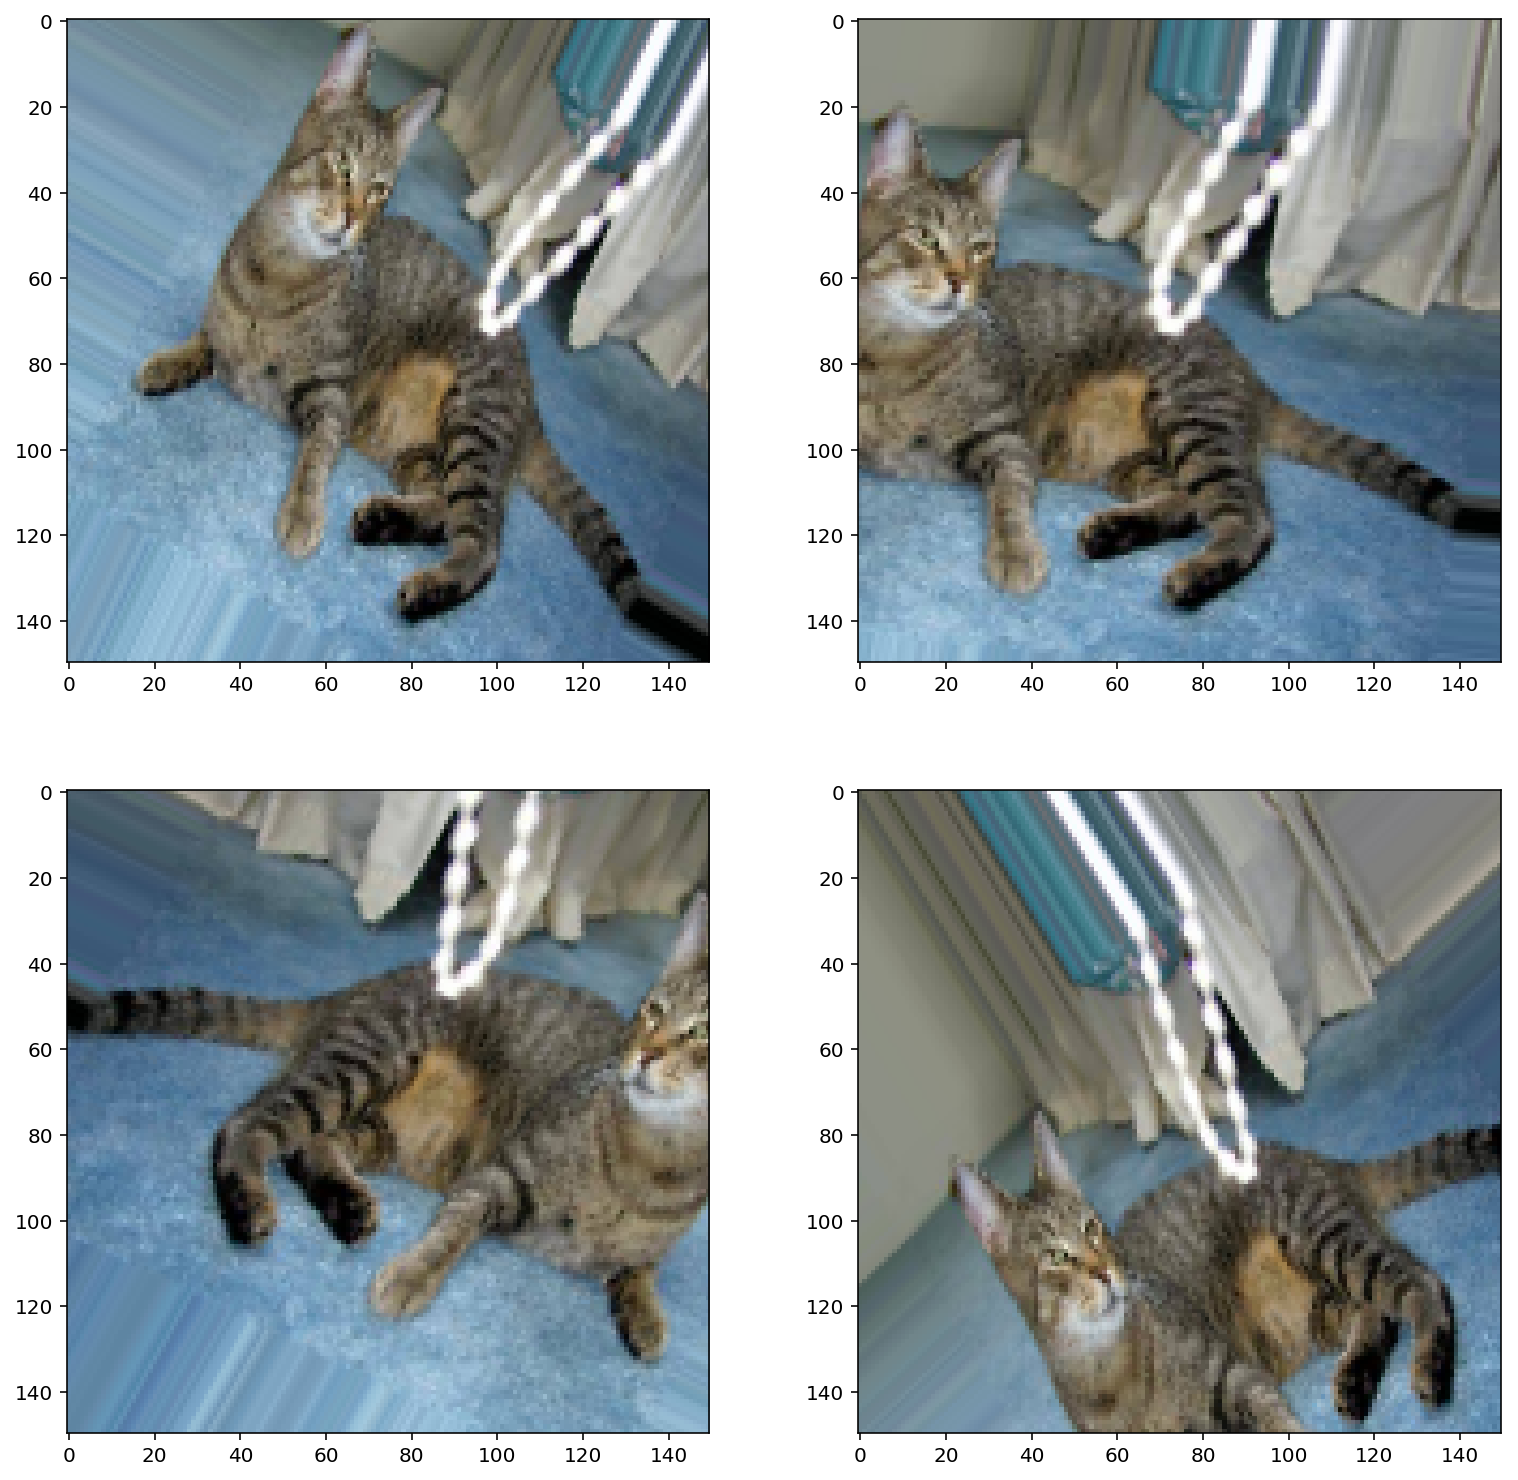

In [23]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = list((sample_dir / "train" / "cats").iterdir())

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
plt.figure(1, figsize=(13, 13))
for i, batch in enumerate(datagen.flow(x, batch_size=1), 1):
    plt.subplot(int("22{}".format(i)))
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    if i % 4 == 0:
        break

plt.show()

## Create model

In [26]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3))
)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

## Create training data generator with augmentation

In [28]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        sample_dir / "train",
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        sample_dir / "validation",
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Fit model

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

In [29]:
import json

models_dir = data_root / "models" 
models_dir.mkdir(exist_ok=True)
history_path = models_dir / "cats_and_dogs_small_with_augmentation_history.json"

In [ ]:
model.save(models_dir / "cats_and_dogs_small_with_augmentation.h5")
with open(history_path, "w") as f:
    json.dump(history.history, f)

In [ ]:
history = json.load(open(history_path))

## Plot training vs test accuracy

In [ ]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15, 20))

plt.subplot(211)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(212)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()